# NRQS

The dynamial equation for density and polarity fields of species $S\in\{A, B\}$ read
$$
\partial_t \rho_S = -\nabla\cdot (v_S \mathbf{p}_S) + D_t \Delta \rho_S, \\
\partial_t \mathbf{p}_S = \frac{v_S}{16 D_r} \Delta(v_S\mathbf{p}_S) - \frac{1}{2}\nabla(v_S\rho_S) - D_r \mathbf{p}_S+D_t\Delta \mathbf{p}_S.
$$
Here, $v_S$ is determined by
$$
v_S(\rho_A(\mathbf{r}), \rho_B(\mathbf{r})) = \bar{v}_{S} \tilde{v}_{SA}(\rho_A(\mathbf{r}))\tilde{v}_{SB}(\rho_B(\mathbf{r})),
$$
with
$$
\begin{aligned}
\tilde{v}_{SA}(\rho_A(\mathbf{r})) &= 1 + \kappa \tanh \left(
		\frac{\eta_{SA}}{\kappa}\frac{\rho_A(\mathbf{r})-\bar{\rho}_A}{\rho_0}
	\right),\\
\tilde{v}_{SB}(\rho_B(\mathbf{r})) &= 1 + \kappa \tanh \left(
		\frac{\eta_{SB}}{\kappa}\frac{\rho_B(\mathbf{r})-\bar{\rho}_B}{\rho_0}
	\right).
\end{aligned}
$$

In [220]:
import numpy as np
import matplotlib.pyplot as plt

def get_tilde_v_XY(eta_XY, rho_Y, bar_rho_Y, kappa=0.7):
    return 1 + kappa * np.tanh(eta_XY/kappa * (rho_Y - bar_rho_Y))

def get_tilde_v(eta_AA, eta_AB, eta_BA, eta_BB, rho_A, rho_B, bar_rho_A, bar_rho_B, kappa=0.7):
    drho_A = rho_A - bar_rho_A
    drho_B = rho_B - bar_rho_B
    inv_kappa = 1. / kappa
    v_AA = 1 + kappa * np.tanh(eta_AA * inv_kappa * drho_A)
    v_AB = 1 + kappa * np.tanh(eta_AB * inv_kappa * drho_B)
    v_BA = 1 + kappa * np.tanh(eta_BA * inv_kappa * drho_A)
    v_BB = 1 + kappa * np.tanh(eta_BB * inv_kappa * drho_B)
    return v_AA, v_AB, v_BA, v_BB

def get_v_A(rho_A, rho_B, bar_rho_A, bar_rho_B, etaAA, etaAB, bar_v_A=1., kappa=0.7):
    v_AA = get_tilde_v_XY(etaAA, rho_A, bar_rho_A, kappa)
    v_AB = get_tilde_v_XY(etaAB, rho_B, bar_rho_B, kappa) 
    return bar_v_A * v_AA * v_AB

def get_v_B(rho_A, rho_B, bar_rho_A, bar_rho_B, etaBA, etaBB, bar_v_B=1., kappa=0.7):
    v_BA = get_tilde_v_XY(etaBA, rho_A, bar_rho_A, kappa)
    v_BB = get_tilde_v_XY(etaBB, rho_B, bar_rho_B, kappa)
    return bar_v_B * v_BA * v_BB

def get_v(rho, etaAA, etaAB, etaBA, etaBB, bar_rho_A=1, bar_rho_B=1, bar_v_A=1, bar_v_B=1, kappa=0.7):
    v_AA, v_AB, v_BA, v_BB = get_tilde_v(etaAA, etaAB, etaBA, etaBB, rho[0], rho[1], bar_rho_A, bar_rho_B, kappa)
    v = np.zeros_like(rho)
    v[0] = bar_v_A * v_AA * v_AB
    v[1] = bar_v_B * v_BA * v_BB
    return v

def get_tilde_v_XY_derive(eta_XY, tilde_v_XY, kappa=0.7):
    return eta_XY * (1 - ((tilde_v_XY - 1)/kappa)**2)

In Fourier space, the equations become
$$
\partial_t \tilde{\rho}_S = -i\left[k_x\widetilde{(v_S p_{x,S})} + k_y\widetilde{(v_S p_{y,S})}\right] - k^2 D_t \tilde{\rho}_S,\\
\partial_t \tilde{p}_{x,S} = \frac{1}{16D_r}\widetilde{v_S\Delta(v_S p_{x,S})} -\frac{i}{2}k_x \widetilde{(v_S \rho_S)} - D_r \tilde{p}_{x, S} - D_t k^2 \tilde{p}_{x,S},\\
\partial_t \tilde{p}_{y,S} = \frac{1}{16D_r}\widetilde{v_S\Delta(v_S p_{y,S})} -\frac{i}{2}k_y \widetilde{(v_S \rho_S)} - D_r \tilde{p}_{y, S} - D_t k^2 \tilde{p}_{y,S},
$$
where $k^2 = k_x^2 + k_y^2$.

In [221]:
dt = 1e-3
spacing = 0.1
Nx = Ny = 128 # Nx and Ny should be even
Lx = Ly = Nx * spacing

ky_1d = np.zeros(Ny)
kx_1d = np.zeros(Nx // 2 + 1)
for i in range(Ny):
    if i < Ny // 2:
        ky_1d[i] = i / (Ny * spacing) * np.pi * 2
    else:
        ky_1d[i] = (i - Ny) / (Ny * spacing) * np.pi * 2
for i in range(Nx // 2 + 1):
    kx_1d[i] = i / (Nx * spacing) * np.pi * 2
kxx, kyy = np.meshgrid(kx_1d, ky_1d)
kx = np.array([kxx, kxx])
ky = np.array([kyy, kyy])
k2 = kx ** 2 + ky ** 2


rho_A0 = 1
rho_B0 = 1
bar_rho_A = 1
bar_rho_B = 1

eta_AA = eta_BB = 0
eta_AB = 2
eta_BA = -2

Dr = 1
Dt = 0.01

np.random.seed(1234)

rho = np.zeros((2, Ny, Nx))
rho[0] =  rho_A0 + (np.random.rand(Ny, Nx) - 0.5) * 0.01
rho[1] =  rho_B0 + (np.random.rand(Ny, Nx) - 0.5) * 0.01

px = (np.random.rand(2, Ny, Nx) - 0.5) * 0.001
py = (np.random.rand(2, Ny, Nx) - 0.5) * 0.001

rho_k =  np.fft.rfft2(rho)
px_k = np.fft.rfft2(px)
py_k = np.fft.rfft2(py)


def show_fields(phi, px, py, t):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4.5), sharex=True, sharey=True, constrained_layout=True)

    extent = [0, Nx * spacing, 0, Ny * spacing]
    im1 = ax1.imshow(phi[0], origin="lower", extent=extent)
    im2 = ax2.imshow(phi[1], origin="lower", extent=extent)
    im3 = ax3.imshow(px[0] **2 + py[0] **2, origin="lower", extent=extent)
    im4 = ax4.imshow(px[1] **2 + py[1] **2, origin="lower", extent=extent)

    cb1 = plt.colorbar(im1, ax=ax1, orientation="horizontal")
    cb2 = plt.colorbar(im2, ax=ax2, orientation="horizontal")
    cb3 = plt.colorbar(im3, ax=ax3, orientation="horizontal")
    cb4 = plt.colorbar(im4, ax=ax4, orientation="horizontal")

    cb2.set_label(r"$\rho_B$")
    cb1.set_label(r"$\rho_A$")
    cb3.set_label(r"$|\mathbf{p_A}|^2$")
    cb4.set_label(r"$|\mathbf{p_B}|^2$")


    fig.suptitle(r"$t=%g$" % t)
    plt.show()
    plt.close()

In [222]:
def exEulerFS(rho, rho_k, px, px_k, py, py_k):
    v = get_v(rho, eta_AA, eta_AB, eta_BA, eta_BB, bar_rho_A, bar_rho_B)

    v_px_k = np.fft.rfft2(v * px)
    v_py_k = np.fft.rfft2(v * py)
    v_rho_k = np.fft.rfft2(v * rho)

    Delta_v_px = np.fft.irfft2(-k2 * v_px_k)
    Delta_v_py = np.fft.irfft2(-k2 * v_py_k)

    tmp1 = np.fft.rfft2(v * Delta_v_px / (16 * Dr))
    tmp2 = np.fft.rfft2(v * Delta_v_py / (16 * Dr))

    rho_k_next = rho_k + dt * (-1j * (kx * v_px_k + ky * v_py_k) - k2 * Dt * rho_k)
    px_k_next = px_k + dt * (tmp1 - 0.5j * kx * v_rho_k - Dr * px_k - Dt * k2 * px_k)
    py_k_next = py_k + dt * (tmp2 - 0.5j * ky * v_rho_k - Dr * py_k - Dt * k2 * py_k)

    rho_next = np.fft.irfft2(rho_k_next)
    px_next = np.fft.irfft2(px_k_next)
    py_next = np.fft.irfft2(py_k_next)

    return rho_next, rho_k_next, px_next, px_k_next, py_next, py_k_next


def run_exEulerFS(rho, rho_k, px, px_k, py, py_k, n_step, dn_out):
    for i in range(n_step):
        if i % dn_out == 0:
            show_fields(rho, px, py, i * dt)
            print(rho.min(), rho.max(), np.mean(rho))
        rho, rho_k, px, px_k, py, py_k = exEulerFS(rho, rho_k, px, px_k, py, py_k)

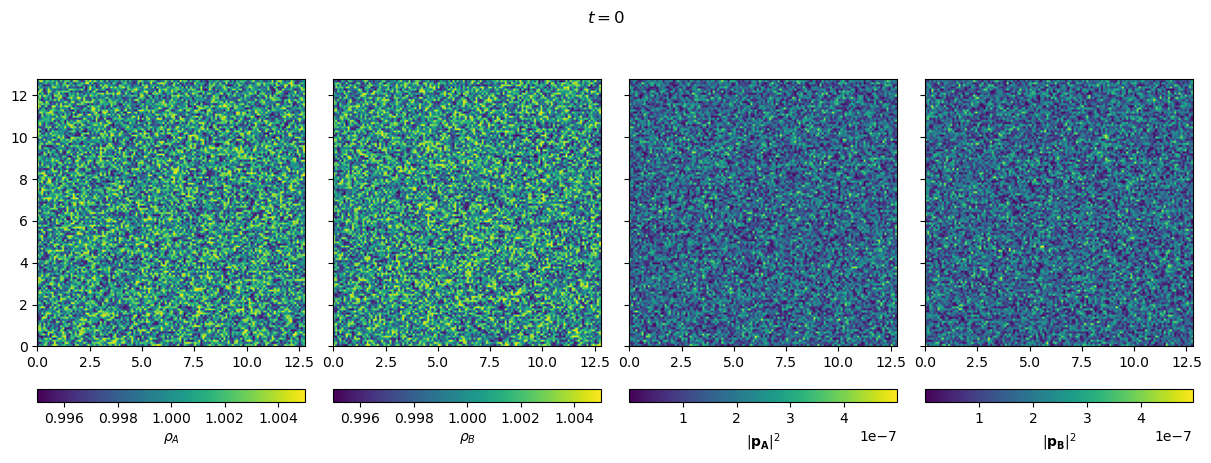

0.9950002591035358 1.0049999641243548 1.0000022756408253


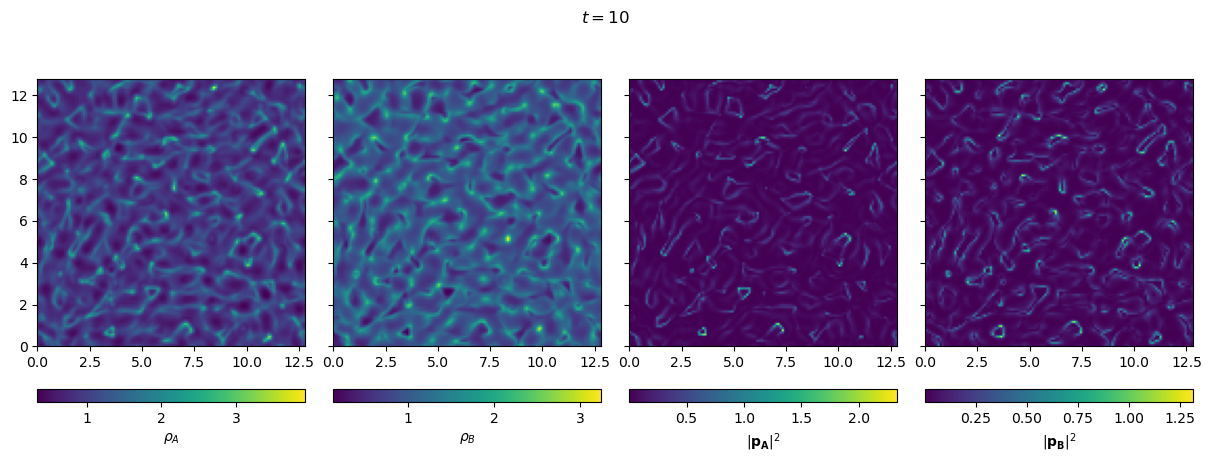

0.12818363631291635 3.926057072665375 1.0000022756408253


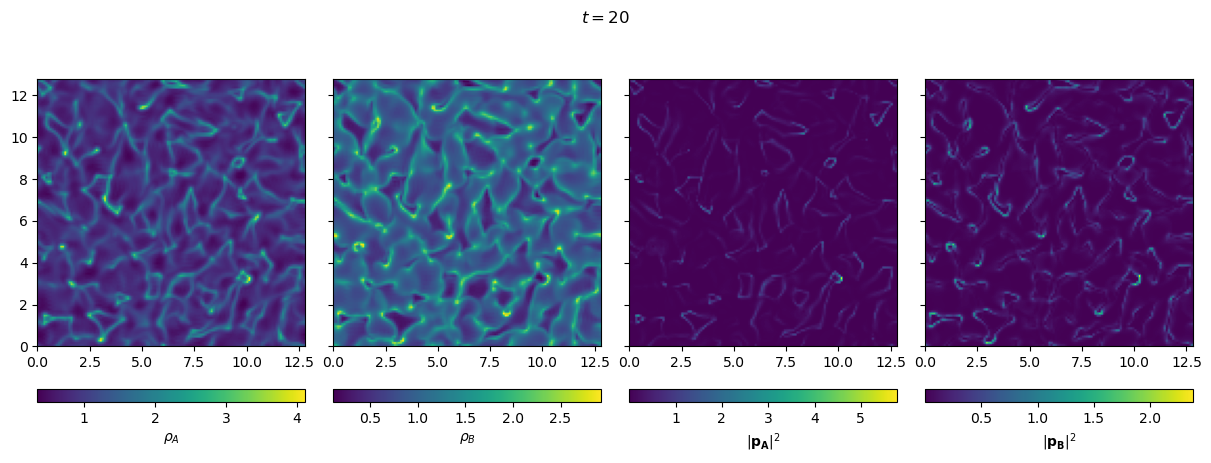

0.11543962126214524 4.113922725879692 1.0000022756408253


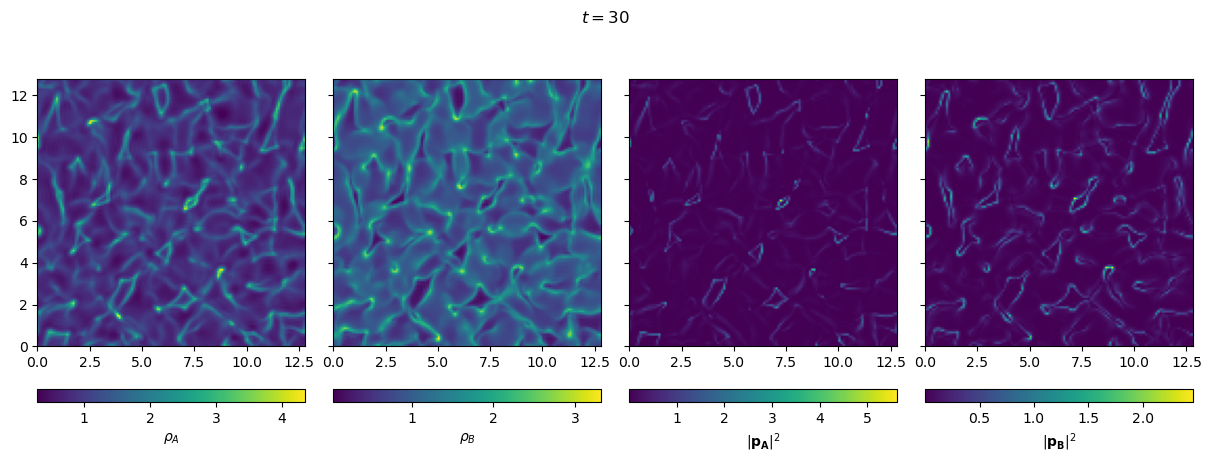

0.040807352912093475 4.346683817201252 1.0000022756408253


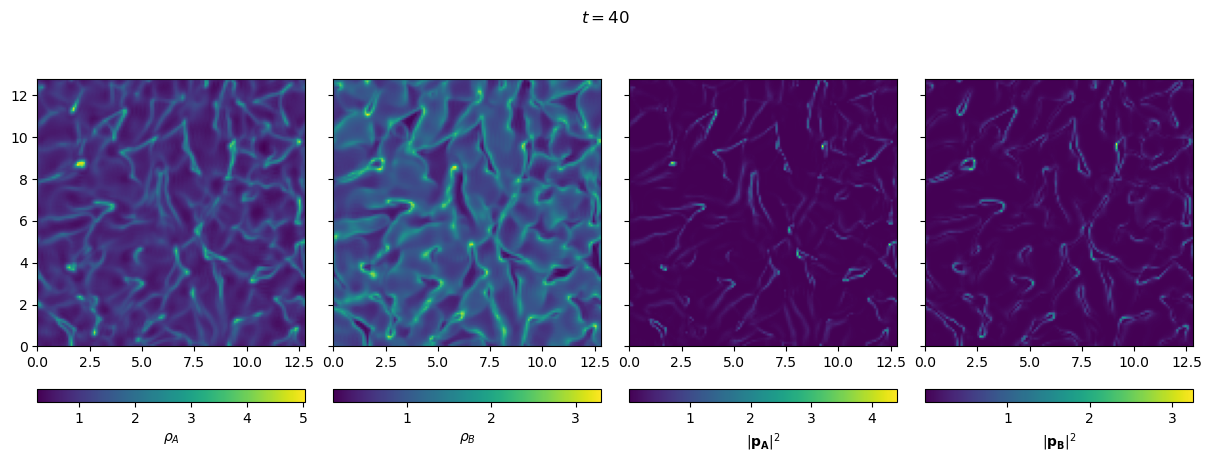

0.1343296845430088 5.034820420294713 1.0000022756408253


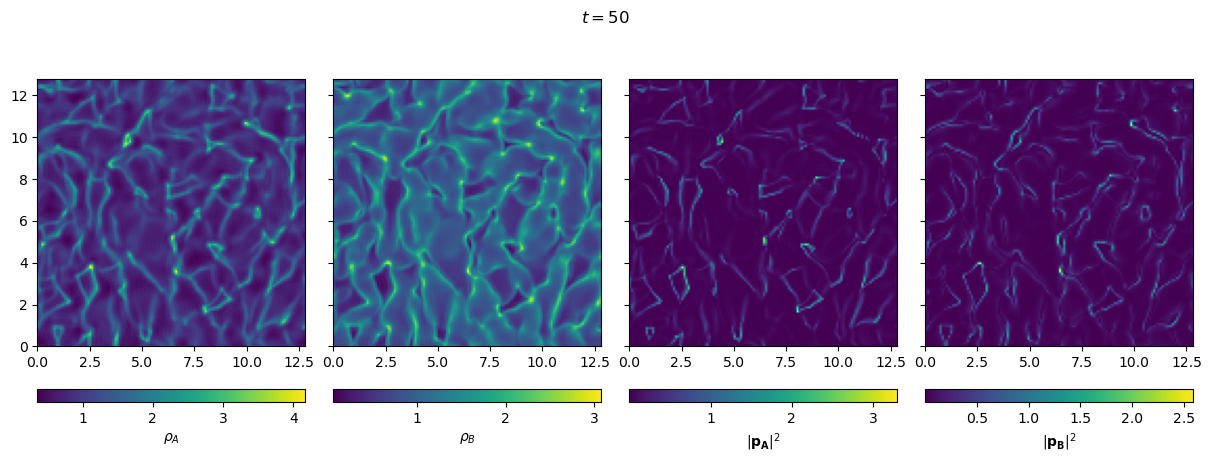

0.053840041654997006 4.165532989126744 1.0000022756408253


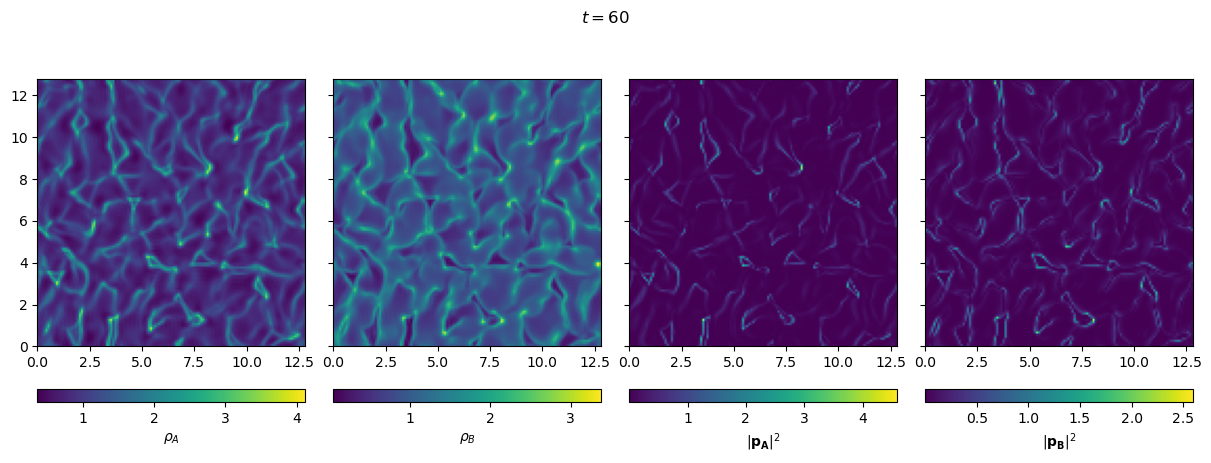

0.052303515994406635 4.117431559845213 1.0000022756408253


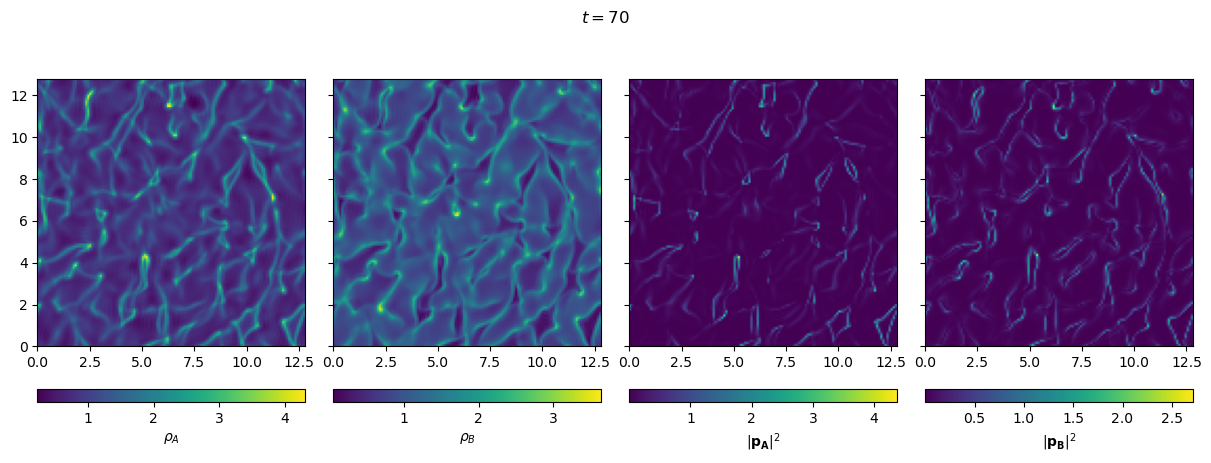

0.05721058174612348 4.302694140016952 1.0000022756408253


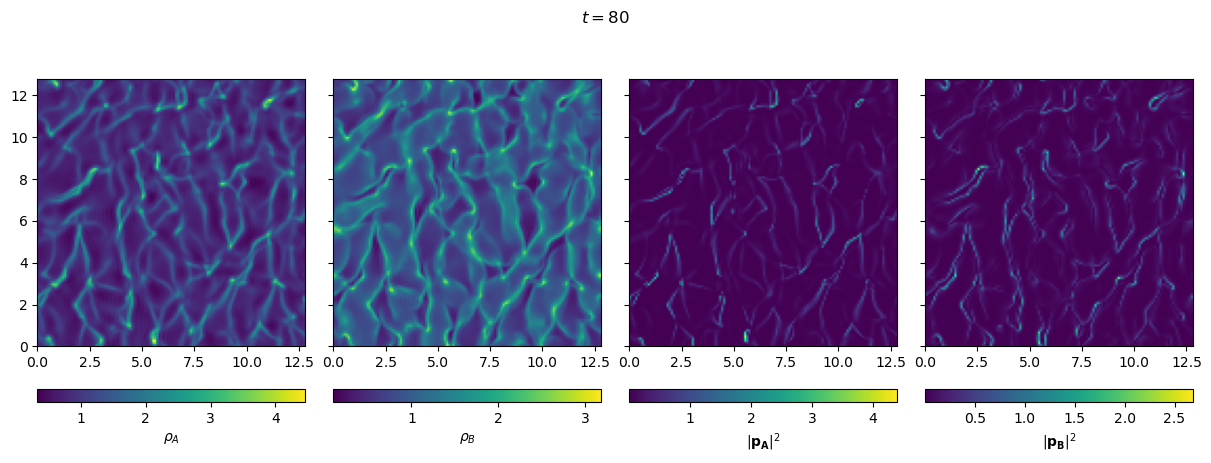

0.10102245310378838 4.45900672936137 1.0000022756408253


KeyboardInterrupt: 

In [223]:
n_step = 500000
dn_out = 10000

run_exEulerFS(rho, rho_k, px, px_k, py, py_k, n_step, dn_out)